# Molecule Attention Transformer


In this turtorial, we will implement Molecule Attention Transformer (MAT) as proposed by [Maziarka et al. (2020)](https://arxiv.org/pdf/2002.08264.pdf). The authors have tested this model on a variety of benchmark datasets. However, we will be focussing only on Blood-Brain Barrier Penetration (BBBP) benchmark. 

Our objective will be to cover the following in this tutorial - 
1. Become familiar with deep learning for molecules.
    - We will look at how the data for molecules look like. 
    - We will build some understanding of various tasks in deep learning for molecules
    

2. Develop our understanding of transformers and attention modules. 

3. Be creative and implement transformers to process molecules and apply it on our benchmark dataset



### Steps
We will go through the following steps 

1. **Investigate data** and build our understanding of the task
2. Implement the **data loader** for training the model
3. Implement the **Molecule Attention Transformer**
4. **Train** the model
5. **Evaluate** the model

### Requirements 

Following python libraries will be required

1. `rdkit`: RDKit is a collection of C++ and Python-based cheminformatics and machine learning tools for working with **small molecules**$^*$, including tools for molecular modeling, substructure searching, fingerprinting, molecular descriptors, and more. 
2. `deepchem`: DeepChem is a Python-based library that provides tools for deep learning in chemistry, including neural network architectures, molecular featurization, and machine learning models for tasks such as molecule generation, drug discovery, and property prediction. It also provides access to pre-trained models and datasets, as well as tools for model evaluation and visualization.
3. `pytorch`: PyTorch is an open-source machine learning library and scientific computing framework that is built on top of Torch. It provides a range of tools and algorithms for building and training neural networks.

____
$^*$ **Small molecules vs other molecules**

Small molecules are typically defined as organic or inorganic compounds with a relatively low molecular weight, usually less than 900 Daltons (Da). These molecules are often used as drugs, probes, or building blocks in various chemical and biological applications. In contrast, other molecules, such as proteins, nucleic acids, and polysaccharides, are typically much larger and more complex than small molecules. Proteins, for example, are made up of long chains of amino acids, which can range in size from a few dozen to several thousand atoms.

There are several ways to distinguish between small molecules and other molecules. One of the most common approaches is based on molecular weight. As mentioned, small molecules are generally considered to have a molecular weight of less than 900 Da, while larger molecules such as proteins and nucleic acids can have molecular weights in the tens or hundreds of thousands of Daltons.

In [1]:
# install these libraries
%%script false


!pip install rdkit
!pip install deepchem
!pip install torch

UsageError: Line magic function `%%script` not found.


In [2]:
from IPython.core.magic import register_cell_magic

from IPython.display import HTML, display

def set_background(color):    
    script = (
        "var cell = this.closest('.jp-CodeCell');"
        "var editor = cell.querySelector('.jp-Editor');"
        "editor.style.background='{}';"
        "this.parentNode.removeChild(this)"
    ).format(color)
    
    display(HTML('<img src onerror="{}" style="display:none">'.format(script)))

@register_cell_magic
def background(color, cell):
    set_background(color)
    return eval(cell)

# Blood-brain barrier penetration 

The blood-brain barrier is a specialized structure in the central nervous system that **separates the circulating blood from the brain tissue**.
It consists of special cells that line the blood vessels in the brain.

The blood-brain barrier is **essential for maintaining the brain's microenvironment and protecting it from potentially harmful substances in the blood**. 
However, it also **presents a significant challenge for drug delivery to the brain**, as many drugs cannot penetrate this barrier.

**Blood-brain barrier penetration** refers to the ability of a substance, such as a drug, to cross the blood-brain barrier and enter the brain tissue. 
The degree of penetration depends on various factors, including the size, charge, and lipophilicity of the molecule. 
Some drugs are designed to have properties that allow them to penetrate the blood-brain barrier, while others require modifications or special delivery methods to achieve this.

# 1. Investigate data


## BBBP

Source: https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html#bbbp-datasets

The blood-brain barrier penetration (BBBP) dataset is designed for the modeling and prediction of barrier permeability. 
As a membrane separating circulating blood and brain extracellular fluid, the blood-brain barrier blocks most drugs, hormones and neurotransmitters. 
Thus penetration of the barrier forms a long-standing issue in development of drugs targeting central nervous system.

- This dataset includes binary labels for over 2000 compounds on their permeability properties.

- Scaffold splitting is recommended for this dataset.

- The raw data csv file contains columns below:

 - **“name”** - Name of the compound

 - **“smiles”** - SMILES representation of the molecular structure (https://tinyurl.com/yjh8um7k)

 - **“p_np”** - Binary labels for penetration/non-penetration


## SMILES representation of the molecular structure

SMILES (**Simplified Molecular Input Line Entry System**) is a string-based notation system used to represent the structure of a molecule. It is a way to encode the molecular structure using a series of alphanumeric characters, which can be easily processed by computer programs.

In SMILES notation, atoms are represented by their atomic symbols, and bonds between atoms are represented by various symbols and characters.
For example, a single bond is represented by a hyphen (-), a double bond is represented by an equals sign (=), and a triple bond is represented by a pound sign (#). 
Other symbols and characters are used to represent aromaticity, chirality, and other properties of the molecule.

One of the advantages of SMILES notation is its simplicity and compactness, which makes it useful for storing and sharing chemical information. 
It is widely used in chemical databases, chemical software, and chemical information systems.

___

# 1. Initial Data Analysis

### Import required libraries

In [3]:
# Import required libraries for data analysis and visualisation
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

import pandas as pd
import rdkit as rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.rdmolops import GetAdjacencyMatrix, GetDistanceMatrix
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
from rdkit import RDLogger
from rdkit.Chem import AllChem

from deepchem.splits import ScaffoldSplitter

import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

import torch
import deepchem

import torch.nn.functional as F
import torch.nn as nn

# fix seed for reproducibility 
rng = np.random.RandomState(1)
torch.manual_seed(rng.randint(np.iinfo(int).max))

# it is a good practice to define `device` globally
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", device)
else:
    device = torch.device("cpu")
    print("No GPU -> using CPU:", device)
    
import pathlib

Skipped loading some Jax models, missing a dependency. No module named 'jax'


Using GPU: cuda


In [4]:
# Get data from MoleculeNet
bbbp = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv")

# Change column name "p_np" to "permeable" for a better readibility
bbbp = bbbp[["smiles", "p_np", "name"]].reset_index(drop=True).rename({"p_np": "permeable"}, axis=1)

In [5]:
bbbp.head()

,smiles,permeable,name
0,[Cl].CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol
1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl,1,Terbutylchlorambucil
2,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...,1,40730
3,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C,1,24
4,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...,1,cloxacillin


#### Look at an example SMILES string

In [6]:
# look at the smiles string
s = bbbp['smiles'][0]
s, type(s)

('[Cl].CC(C)NCC(O)COc1cccc2ccccc12', str)

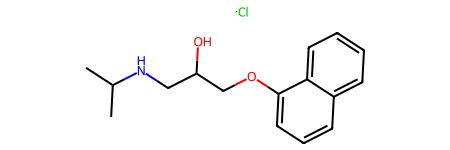

In [7]:
# Visualize this molecule
mol = Chem.MolFromSmiles(s)
mol

In [8]:
# There are numeerous things that you can do with `rdkit.Chem.rdchem.Mol` object.
# more on that here - https://www.rdkit.org/docs/GettingStartedInPython.html#working-with-molecules
print(f'Type of mol: {type(mol)}')
print(f'Number of atoms: {mol.GetNumAtoms()}')


Type of mol: <class 'rdkit.Chem.rdchem.Mol'>
Number of atoms: 20


#### Choosing the fragment of the molecule 

In the context of molecular modeling and drug discovery, it is often useful to work with **simplified representations of complex molecules**. 
One way to simplify a molecule is to extract the largest fragment, which is the part of the molecule that contains the most atoms and is most likely to have the dominant biological activity.

In some cases, a molecule may contain multiple fragments that have different biological activities or toxicities. In these cases, it may be desirable to extract only the largest fragment, which is likely to contain the most relevant or active part of the molecule, while removing any potentially harmful or irrelevant fragments.

[02:12:29] Running LargestFragmentChooser
[02:12:29] Fragment: [Cl]
[02:12:29] New largest fragment: [Cl] (1)
[02:12:29] Fragment: CC(C)NCC(O)COc1cccc2ccccc12
[02:12:29] New largest fragment: CC(C)NCC(O)COc1cccc2ccccc12 (40)


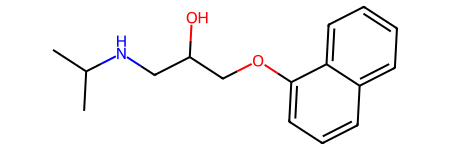

In [9]:
LargestFragmentChooser().choose(mol)

<div class="alert-info">
<br>
<strong>Note</strong>: Chlorine has been removed.
<br><br>
</div>

#### Molecular Fingerprint 

Using a string representation (SMILES) is one way to represent molecules.
Though readable, this simplification doesn't capture intricacies of atoms and their connecitivity. 

One way they do this is by using special codes called "fingerprints" to describe the molecules. 
These fingerprints help scientists understand what each molecule is made of and how it's put together.

One type of fingerprint is called a **"Morgan fingerprint"**. 
It works like a map of the molecule, showing all the little parts (called "substructures") that make it up. 
The fingerprint is made by going all around the molecule, and looking at each group of atoms (the tiny building blocks that make up the molecule) in turn.

Then, for each group of atoms, the Morgan fingerprint gives it a special code (called a "hash"). 
This code tells us what the group of atoms looks like and how it's connected to the other parts of the molecule.
The `radius` is set in advanced to determine the number of hops to consider from the concerned atom. 
And by putting all these codes together in a long list, we get the fingerprint for the whole molecule!

Even though the Morgan fingerprint is a code, it still tells us important things about the molecule. 
For example, we can use it to compare one molecule to another and see how similar they are. 
This is really useful when scientists want to find molecules that work in the same way, like medicines that can treat the same disease.

The resulting set of hashed substructures is then used to generate a **binary bit vector**, where each bit represents the presence or absence of a particular substructure in the molecule. 
The length of the bit vector can vary depending on the size and complexity of the substructure set, but typically ranges from a few hundred to tens of thousands of bits.

In [10]:
np.array(Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048))

array([0, 1, 0, ..., 0, 0, 0])

#### Defining few useful functions

In [11]:
# Define few functions that we need for processing data.
# Note: Original source for the utility functions used below is
# https://blog.reverielabs.com/mapping-chemical-space-with-umap/

def get_largest_fragment_from_smiles(s: str):
    mol = Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return Chem.MolToSmiles(clean_mol)
    return None

def compute_ecfp_descriptors(smiles_list):
    """ Computes ecfp descriptors """
    
    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp = _compute_single_ecfp_descriptor(smiles)
        if ecfp is not None:
            keep_idx.append(i)
            descriptors.append(ecfp)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp)
    
    return None

In [12]:
# check the above defined functions
x = get_largest_fragment_from_smiles(bbbp['smiles'][0])
print(x)

x, y = compute_ecfp_descriptors(bbbp['smiles'][:2])
print(x, x.shape, y)


CC(C)NCC(O)COc1cccc2ccccc12
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] (2, 2048) [0, 1]


[02:12:29] Running LargestFragmentChooser
[02:12:29] Fragment: [Cl]
[02:12:29] New largest fragment: [Cl] (1)
[02:12:29] Fragment: CC(C)NCC(O)COc1cccc2ccccc12
[02:12:29] New largest fragment: CC(C)NCC(O)COc1cccc2ccccc12 (40)


### Loading and cleaning up data

In [ ]:
# Remove extra fragments in SMILES since they are not relevant to BBB permeability
bbbp["smiles"] = bbbp["smiles"].apply(get_largest_fragment_from_smiles).dropna()

In [14]:
bbbp.head()

,smiles,permeable,name
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin


In [15]:
bbbp['permeable'].value_counts()

1    1567
0     483
Name: permeable, dtype: int64

<div class="alert-info">
<br>
<strong>Note</strong>: The dataset has a class imbalance
<br><br>
</div>

In [16]:
## Data Transformation
# Compute desrciptors while keeping track of the ones that failed
ecfp_descriptors, keep_idx = compute_ecfp_descriptors(bbbp["smiles"])

# Keep only the ones that we were able to generate features for
bbbp = bbbp.iloc[keep_idx]

#### Visualising molecules via PCA embeddings of fingerprints

The fingerprints, as explained above, carries important information about the type of atoms and the corresponding structural information.
This structural information lend the molecules to its characteristics properties. 

Thus, doing PCA on these fingerprints may allow us to visualize how the molecules might be clustered together.


In [17]:
# Get PCA embeddings
pca = PCA(n_components=2)
X_pca = pca.fit_transform(ecfp_descriptors)
bbbp["x0"], bbbp["x1"] = X_pca[:,0], X_pca[:,1]

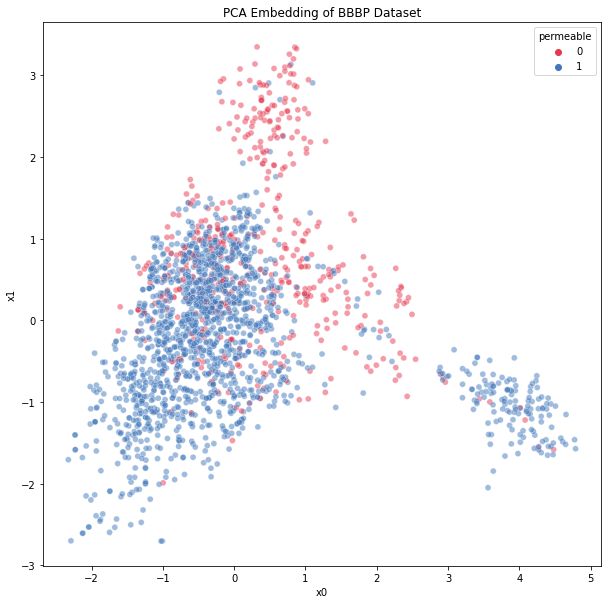

In [18]:
# Scatter plot
palette = sns.color_palette(["#E8384F", "#4178BC"])
plt.figure(figsize=(10,10))
sns.scatterplot(data=bbbp,
                x="x0",
                y="x1",
                hue="permeable",
                alpha=0.5,
                palette=palette)
plt.title("PCA Embedding of BBBP Dataset")
plt.show()

In [19]:
# Remvoe PCA embeddings to clean up the df and print the summary of the data
bbbp = bbbp.drop(labels=['x0', 'x1'], axis=1)
bbbp

,smiles,permeable,name
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin
...,...,...,...
2045,O=c1[nH]c2cc(Cl)c(Cl)c([N+](=O)[O-])c2[nH]c1=O,1,licostinel
2046,C[S+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2cnc...,1,ademetionine(adenosyl-methionine)
2047,CC(Cc1ccccc1)n1cc([N-]C(=O)Nc2ccccc2)[o+]n1,1,mesocarb
2048,CCc1c(C)[n+]([NH-])c(-c2ccc(OC)c(OC)c2)c2cc(OC...,1,tofisoline


# 2. Data Loader

We aim to do the following in this section

1. Understand how to convert SMILES to a graphical representation
2. Understand how to create features for these molecules
3. Understand how to split data for cross-validation

#### SMILES to Graphical representation of molecules

**Q**: How do we convert SMILES representation of molecules to graph?

We need the following: 
1. Adjacency matrix
2. Node features
3. Edge features

We will be using a lot of `rdkit` modules to extract these features, e.g., `rdkit.Chem.rdmolops`

In [20]:
# adjacency matrix
mol = Chem.MolFromSmiles(bbbp['smiles'][0])
adj = GetAdjacencyMatrix(mol)
print(f'Number of atoms: {mol.GetNumAtoms()}, Shape of the adjacency matrix: {adj.shape}')

Number of atoms: 19, Shape of the adjacency matrix: (19, 19)


We can get a distance matrix too. `GetDistanceMatrix` usees an algorithm called "atom typing" to assign atomic symbols and coordinates to the atoms in the molecule. This algorithm uses rules based on the SMILES syntax and valence infomration to determine the number of bonds that each atom forms, and to assign approximate 3d coordinates to each atom based on the bond topology.


In [21]:
dist = GetDistanceMatrix(mol)
dist[:6, :6] 

array([[0., 1., 2., 2., 3., 4.],
       [1., 0., 1., 1., 2., 3.],
       [2., 1., 0., 2., 3., 4.],
       [2., 1., 2., 0., 1., 2.],
       [3., 2., 3., 1., 0., 1.],
       [4., 3., 4., 2., 1., 0.]])

Finally, we need to extract atom features and bond features. 
We will use the standard practices to do so. 
I found [this](https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/) tutorial useful, so we will follow their code to extract these features.

#### Featurization of molecules

In [22]:
# Source: https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/


def one_hot_encoding(x, permitted_list):
    if x not in permitted_list:
        x = permitted_list[-1]
    
    return [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]


def get_atom_features(atom, 
                      use_chirality = True, 
                      hydrogens_implicit = True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """

    # define list of permitted atoms
    
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']
    
    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms
    
    # compute atom features
    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)
    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])
    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])
    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])
    is_in_a_ring_enc = [int(atom.IsInRing())]
    is_aromatic_enc = [int(atom.GetIsAromatic())]
    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]
    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]
    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]
    
    # concatenate 
    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled
          
    # additional features
    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc
    
    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)


def get_bond_features(bond, 
                      use_stereochemistry = True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    # compute features
    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)
    bond_is_conj_enc = [int(bond.GetIsConjugated())]
    bond_is_in_ring_enc = [int(bond.IsInRing())]
    
    # concatenate them
    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc
    
    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)



Get the total number of features for atoms and edges to be used for defining the models.

In [23]:
unrelated_smiles = "O=O"  # create a dummy colecule
unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0))) # pass a dummy atom
n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))# pass a dummy bond


print(f'Number of atom features: {n_node_features}')
print(f'Number of edge features: {n_edge_features}')

Number of atom features: 79
Number of edge features: 10


#### Optimized placement of atoms in the molecules from SMILES

There is a possibility of optimizing the placement of atoms in the resulting molecule from SMILES representation. 

`UFFOptimizedMolecule` is a function in the RDKit cheminformatics library that optimizes the 3D structure of a molecule using the Universal Force Field (UFF) method.

The UFF method is a widely used force field in computational chemistry that models the energy of a molecule as a function of its atomic positions. 
The method takes into account various factors such as bond stretching, bond angle bending, and torsion angles, and uses a set of empirical parameters to calculate the energy associated with each configuration of the molecule.
The UFF method can be used to generate a low-energy 3D structure of a molecule by finding the configuration with the minimum energy.

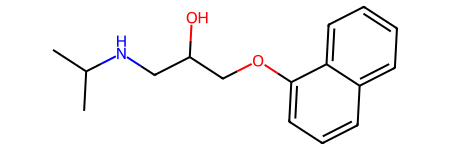

In [24]:
mol = Chem.MolFromSmiles(bbbp['smiles'][0])
mol

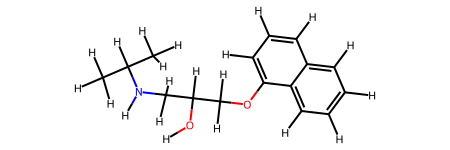

In [25]:
# Add hydrogen atoms
mol = Chem.AddHs(mol)
mol

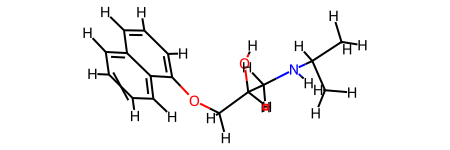

In [26]:
# embed this molecule
AllChem.EmbedMolecule(mol, maxAttempts=5000)
mol

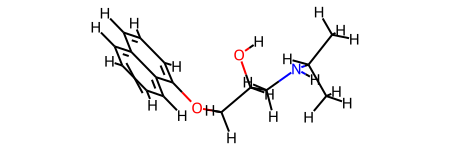

In [27]:
# Use UFFOptimizedMolecule for placement
AllChem.UFFOptimizeMolecule(mol)
mol

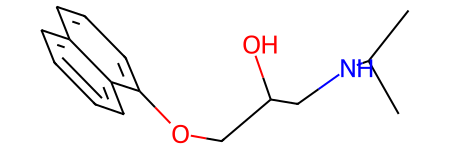

In [28]:
# remove hydrogens
mol = Chem.RemoveHs(mol)
mol

In [29]:
# define a function to do so
def construct_mol(mol):
    """
    Alters `mol` based on the optimized placement. 
    Source: https://github.com/deepchem/deepchem/blob/master/deepchem/feat/molecule_featurizers/mat_featurizer.py#L56
    """
    try:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol, maxAttempts=5000)
        AllChem.UFFOptimizeMolecule(mol)
        mol = Chem.RemoveHs(mol)
    except ValueError:
        AllChem.Compute2DCoords(mol)

    return mol

#### Dummy Node

Maziarka et al. (2020) suggests using a dummy node for superior performance. 

In [30]:
def add_dummy_node(mat, mat_type='adj'):
    """
    Adds a dummy node. See section 4.4 of Maziarka et al. (2020).
    Args:
        mat (torch.tensor): matrix to add a dummy node to
        mat_type (str): type of matrix
    """
    
    n_nodes = mat.shape[0]
    if mat_type == 'adj':
        out = np.zeros((n_nodes + 1, n_nodes + 1))
        out[:-1, :-1] = mat
        return out
    
    if mat_type == 'dist':
        out = np.full((n_nodes + 1, n_nodes + 1), 1e6)
        out[:-1, :-1] = mat
        return out 
    
    if mat_type == 'node_features':
        out = np.zeros((n_nodes + 1, mat.shape[1] + 1))
        out[:-1, :-1] = mat
        out[-1, -1] = 1  # one hot encode dummy node
        return out
    
    if mat_type == 'edge_features':
        n_edge_features = mat.shape[-1]
        out = np.zeros((n_nodes + 1, n_nodes + 1, n_edge_features + 1))
        out[:-1, :-1, :-1] = mat
        out[..., -1] = -1
        
        return out
        
    

#### Collect data

Puttting all of the above together.

In [31]:
# Data collection adapted from https://www.blopig.com/blog/2022/02/how-to-turn-a-smiles-string-into-a-molecular-graph-for-pytorch-geometric/
unrelated_smiles = "O=O"
unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

USE_OPTIMIZED_PLACEMENT = True # data creation will take time (see section 3 (other details))
USE_DUMMY_NODE = True

idx, data, scaffolds = 0, [], {}
for smiles, permeable in zip(bbbp['smiles'], bbbp['permeable']):
    # convert SMILES to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)
    
    if USE_OPTIMIZED_PLACEMENT:
        mol = construct_mol(mol)
    
    # get feature dimensions
    n_nodes = mol.GetNumAtoms()
    n_edges = 2*mol.GetNumBonds()

    # construct node feature matrix X of shape (n_nodes, n_node_features)
    X = np.zeros((n_nodes, n_node_features))
    for atom in mol.GetAtoms():
        X[atom.GetIdx(), :] = get_atom_features(atom)

    adjacency_matrix = GetAdjacencyMatrix(mol)
    (rows, cols) = np.nonzero(adjacency_matrix)
    distance_matrix = GetDistanceMatrix(mol)
    ef_matrix = np.zeros(list(adjacency_matrix.shape) + [n_edge_features])
    for i,j in zip(rows, cols):
        ef_matrix[i, j, :] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))

    if USE_DUMMY_NODE:
        adjacency_matrix = add_dummy_node(adjacency_matrix, 'adj')
        distance_matrix = add_dummy_node(distance_matrix, 'dist')
        ef_matrix = add_dummy_node(ef_matrix, 'edge_features')
        X = add_dummy_node(X, 'node_features')

    # convert to torch tensor
    X = torch.tensor(X, dtype = torch.float)
    adjacency_matrix = torch.tensor(adjacency_matrix, dtype=torch.float)
    distance_matrix = torch.tensor(distance_matrix, dtype=torch.float)
    ef_matrix = torch.tensor(ef_matrix, dtype = torch.float)
    
    scaffold = deepchem.splits.splitters._generate_scaffold(smiles)
    if scaffold in scaffolds:
        scaffolds[scaffold].append(idx)
    else:
        scaffolds[scaffold] = [idx]
    
    # Note: we don't use ef_matrix as per the Appendix E of Maziarka et al. But we can experiment with other ways to use ef_matrix.
    data.append([X, adjacency_matrix, distance_matrix, ef_matrix, permeable])
    idx += 1
    
    if idx % 250 == 0:
        print(f'# data collected: {idx}')

# data collected: 250
# data collected: 500
# data collected: 750
# data collected: 1000
# data collected: 1250
# data collected: 1500
# data collected: 1750
# data collected: 2000


[02:18:28] UFFTYPER: Unrecognized charge state for atom: 1
[02:18:28] UFFTYPER: Unrecognized charge state for atom: 1


#### Pad data

Let's put all of the above dataset in big tensors.

In [32]:
max_nodes = max(x[0].shape[0] for x in data)
min_nodes = min(x[0].shape[0] for x in data)

In [33]:
# data matrices
n_mols = bbbp['smiles'].shape[0]
X = torch.zeros(size=[n_mols, max_nodes, n_node_features + USE_DUMMY_NODE])
A = torch.zeros(size=[n_mols, max_nodes, max_nodes])
D = torch.zeros(size=[n_mols, max_nodes, max_nodes])
EF = torch.zeros(size=[n_mols, max_nodes, max_nodes, n_edge_features + USE_DUMMY_NODE])
Y = torch.zeros(size=[n_mols])

In [34]:
# pad sequences
for idx, (x, a, d, ef, p) in enumerate(data):
    n_nodes = x.shape[0]
    X[idx, :n_nodes] = x
    A[idx, :n_nodes, :n_nodes] = a
    D[idx, :n_nodes, :n_nodes] = d
    EF[idx, :n_nodes, :n_nodes, :] = ef
    Y[idx] = p

#### Scaffold splitting 

Source: [Reverie labs](https://blog.reverielabs.com/mapping-chemical-space-with-umap/)
> A fundamental assumption behind most machine learning methods is that data are independent and identically distributed (IID). However, in drug discovery datasets, compounds are almost never sampled independently, as they are typically extracted from experiments for specific therapeutic programs. Measurements often follow the patterns of the drug development efforts that generate them. Any biases in the data-generation process can also sneak into the training and evaluation of models. In practice, this means that open source and industry datasets are often “clumpy”, consisting of measurements for compounds that are very similar to one another and non-uniformly cover chemical space.

**Q**: How do we ensure that the training dataset has a diverse set of molecules for the models to generalize well?

We use `scaffolds` to categorize molecules. Each molecule is classified based on their scaffold. The final dataset can be split stratified on these scaffolds. 
The idea behind scaffold splitting is to identify the core structure or scaffold of a molecule, and then to split the dataset into different groups based on the similarity of their scaffolds. 

The `_generate_scaffold` function in DeepChem takes a SMILES string as input and uses a series of rules to identify the scaffold of the molecule. Specifically, the function identifies the largest non-cyclic substructure in the molecule and removes all substituents from that substructure, leaving only the core scaffold. The resulting scaffold is represented as a SMILES string.



In [35]:
scaffold = deepchem.splits.splitters._generate_scaffold(bbbp['smiles'][0])
scaffold

'c1ccc2ccccc2c1'

In [36]:
splitter = ScaffoldSplitter()
n_mols = bbbp['smiles'].shape[0]
dataset = deepchem.data.NumpyDataset(X=np.arange(n_mols), ids=bbbp['smiles'])
train, valid, test = splitter.train_valid_test_split(dataset, frac_train=0.8, frac_valid=0.1, seed=0)

In [37]:
train_idx, valid_idx, test_idx = train.X, valid.X, test.X

#### Dataloader

Finally, we can prepare a dataloader that can be used by PyTorch.

In [38]:
# prepare a dataloader
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, A, D, EF, Y):
        self._X = X
        self._A = A
        self._D = D
        self._EF = EF
        self._Y = Y
    
    def __len__(self):
        return self._X.shape[0]

    def __getitem__(self, index):
        return self._X[index], self._A[index], self._D[index], self._EF[index], self._Y[index]

dataset = Dataset(X, A, D, EF, Y)    

class Subdataset(torch.utils.data.Dataset):
    def __init__(self, dataset, idxs):
        self._data = dataset
        self._idxs = idxs
        
    def __len__(self):
        return len(self._idxs)
    
    def __getitem__(self, index):
        return self._data[self._idxs[index]]

train_data = torch.utils.data.DataLoader(Subdataset(dataset, train_idx), batch_size=2, num_workers=2)

# 3. Model definition

We will implement the Molecule Attention Transformer as proposed by Maziarka et al. (2020).

<img src="MAT.png">


Remember attention computes the scores based on keys and queries
    
$$A = \text{Softmax}(\frac{QK^T}{\sqrt{d}})$$

MAT modulates these scores through the addition of scores computed using adjacency and distance matrix.
    
$$A^{'} = \lambda_a \text{Softmax}(\frac{QK^T}{\sqrt{d}}) + \lambda_g \mathbf{A} + \lambda_d g(\mathbf{D})$$

Here, both keys and queries are going to be derived from the atomic features (self-attention), $g(\mathbf{D})$ is a distance kernel function to modify distance matrix, $\lambda_g$, $\lambda_a$ and $\lambda_d$ are tthe hyperparameters.

To do this, we need the following classes

    1. MoudlatedMultiHeadAttention (MMHA): To implement attention scheme discussed above
    2. EncoderLayer: This layer implements the block in which MMHA lies. It also carries out operations surrounding it.
    3. MAT: The class to carry out all other operations, e.g., embedding, global pooling, and prediction. 


In [39]:
class ModulatedMultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, lambda_a, lambda_g, lambda_d, dist_kernel_fn, dropout=0.0): 
        """
        Implementation of attention as explained in Eq. 2 of Maziarka et al. 2020.
        
        """
        super().__init__()
        
        self.lambda_a, self.lambda_g, self.lambda_d = lambda_a, lambda_g, lambda_d
        self.dist_kernel_fn = dist_kernel_fn
        
        self.n_heads = n_heads
        self.d_model = d_model     
        self.d_head = d_model // n_heads
        
        self.Q = nn.Linear(d_model, d_model)
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
            
        
    def forward(self, q, k, v, adjacency_mat=None, distance_mat=None, mask=None):
        """
        modulations (list(torch.tensor)): list of square tensors to modulate the attention weights with. 
        """
        lambda_a = self.lambda_a
        lambda_g = self.lambda_g
        lambda_d = self.lambda_d

        batch_size = q.shape[0]
        
        # break the output such that the last two dimensions are heads x d_head
        Q = self.Q(q).view(batch_size, -1, self.n_heads, self.d_head)
        K = self.K(k).view(batch_size, -1, self.n_heads, self.d_head)
        V = self.V(v).view(batch_size, -1, self.n_heads, self.d_head)
        
        # take transpose so that last two dimensions are max_length x d_head
        Q = Q.transpose(1, 2)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)
        
        # bs x n_heads x max_length x max_length
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_head)

        if mask is not None:
            scores = scores.masked_fill(mask==0, -1e9)
            
            if adjacency_mat is not None:
                adjacency_mat = adjacency_mat.masked_fill(mask==0, 0.0)
            
            if distance_mat is not None:
                distance_mat = self._mask_distance_matrix(distance_mat, mask)

        attn = scores.softmax(dim=-1) * lambda_a
        
        if adjacency_mat is not None:
            attn = attn + lambda_g * adjacency_mat[:, None, :, :]
        
        if distance_mat is not None:
            dist_mat = self._normalize_distance_mat(distance_mat)
            attn = attn + lambda_d * dist_mat[:, None, :, :]

        attn = self.dropout(attn)
        output = torch.matmul(attn, V)
        
        # transpose back to get batch_size x max_length x d_model
        # use contiguous to reset the ordering of elements (i.e. stride and offset): https://stackoverflow.com/a/52229694/3413239
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        return output

    def _mask_distance_matrix(self, mat, mask):
        if self.dist_kernel_fn == 'exp':
            mask_value = 1e9
        
        elif self.dist_kernel_fn == 'softmax':
            mask_value = -1e9
        
        else:
            raise ValueError(f'Unrecognized dist_kernel_fn:{self.dist_kernel_fn}')
        
        return mat.masked_fill(mask==0, mask_value)
    
    def _normalize_distance_mat(self, mat):
        if self.dist_kernel_fn == 'exp':
            return torch.exp(-mat)
        
        if self.dist_kernel_fn == 'softmax':
            return torch.softmax(mat, dim=-1)
        
        raise ValueError(f'Unrecognized dist_kernel_fn:{self.dist_kernel_fn}')

In [40]:
# example call
mha = ModulatedMultiHeadAttention(2, 6, 0.1, 0.1, 0.1, 'exp', 0.0)

B = 2
N = 5
dim = 6
Q = torch.randn((B, N, dim)) #  batches,  max length, dimensions
K = torch.randn((B, N, dim)) 
V = torch.randn((B, N, dim)) 
mask = torch.triu(torch.ones((B, N, N)))
adj = torch.randn(B, N, N)
dist = torch.randn(B, N, N)

A = mha(Q, K, V, adj, dist, mask)
print(A)


tensor([[[-0.0139, -0.1072, -0.0572,  0.1278, -0.0984, -0.0491],
         [-0.0198,  0.0922, -0.1367,  0.0219, -0.1683, -0.0546],
         [ 0.0242,  0.1045, -0.1627, -0.0070, -0.2203, -0.0531],
         [-0.0992,  0.1846, -0.1066,  0.2520, -0.1157, -0.1003],
         [ 0.0649, -0.0450, -0.0753, -0.1332, -0.1020,  0.0087]],

        [[ 0.1440,  0.0198, -0.5124, -0.1653, -0.3818, -0.2029],
         [ 0.2019,  0.0008, -0.3956, -0.2208, -0.2558, -0.2931],
         [ 0.0978,  0.0077, -0.3080, -0.2811, -0.0982, -0.2294],
         [ 0.1752, -0.0483,  0.2398,  0.1153, -0.3855,  0.2745],
         [ 0.0953, -0.0238,  0.1622,  0.0765, -0.2265,  0.1734]]],
       grad_fn=<ViewBackward0>)


In [41]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, lambda_a, lambda_g, lambda_d, dist_kernel_fn='exp', dropout=0.0, d_ff=None):
        
        super().__init__()
                
        # mha
        self.mmha = ModulatedMultiHeadAttention(n_heads, d_model, lambda_a, lambda_g, lambda_d, dist_kernel_fn, dropout)
        self.prenorm = nn.LayerNorm(d_model)

        if d_ff is None:
            d_ff = d_model

        # feed forward (K=2)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.postnorm = nn.LayerNorm(d_model)
        
        # dropout regularization
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, A, D, mask):
        x = self.prenorm(x)
        z = self.mmha(x, x, x, A, D, mask) # mha
        z = self.dropout(z) # refer to the section 5.4 of Vaswani et al.
        
        x = self.postnorm(x + z) # add & norm
        z = self.ff(x) # feed forward
        z = self.dropout(z) # refer to the section 5.4 of Vaswani et al. 
        x = x + z # add 
        return x

In [42]:
# example call 
B = 2
N = 5
dim = 6

enc = EncoderLayer(dim, 2, 0.1, 0.1, 0.1)
x = torch.randn((B, N, dim)) #  batches,  max length, dimension
mask = torch.triu(torch.ones((B, N, N)))
A = torch.randn(B, N, N)
D = torch.randn(B, N, N)
enc(x, mask, A, D)

tensor([[[ 1.9623, -0.1059, -0.2459, -1.1328,  0.5533, -0.9389],
         [ 1.9075, -0.9382, -1.1500, -1.0456,  0.2034,  1.2769],
         [ 0.7500,  0.3872, -1.0984,  0.5785, -0.8360,  1.3522],
         [ 0.0993,  1.1316, -0.3916,  0.7739, -1.0672,  1.1093],
         [ 0.6053,  0.8138, -1.2374, -0.0412,  0.5900, -1.1871]],

        [[ 0.7300, -0.9127, -0.5091, -1.0292,  2.0399, -0.1645],
         [-0.1580,  1.2041, -0.8242, -0.6149,  1.0886, -1.1003],
         [-0.3226,  1.2870, -1.5820, -0.7606,  0.7038,  0.9752],
         [-1.0779,  0.5834,  0.6607, -1.5353,  1.2529,  0.3001],
         [ 0.6433,  1.3060,  0.5312, -1.7892, -0.4733,  0.0076]]],
       grad_fn=<AddBackward0>)

In [43]:
class MAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, depth, 
        n_heads = 8,
        lambda_g = 0.5,
        lambda_d = 0.5,
        lambda_a = 1,
        dropout = 0.0,
        dist_kernel_fn = 'exp'):

        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.depth = depth
        
        self.input_repr_fn = nn.Linear(input_dim, hidden_dim)
        self.layers = nn.ModuleList([])

        for _ in range(depth):
            self.layers.append(EncoderLayer(hidden_dim, n_heads, lambda_a, lambda_g, lambda_d, dist_kernel_fn, dropout))

        self.postnorm = nn.LayerNorm(hidden_dim)
        self.ff_out = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, adjacency_mat = None, distance_mat = None, mask = None):
        x = self.input_repr_fn(x)  # embedding
        for enc in self.layers:
            x = enc(x, adjacency_mat, distance_mat, mask)
        x = self.postnorm(x)
        x = x.mean(dim=-2) # global pooling
        return self.ff_out(x).squeeze()

In [44]:
# example call
in_dim = 2
hidden_dim=4
out_dim=1
depth=2
heads=2
mat = MAT(in_dim, hidden_dim, out_dim, depth, heads)

B = 2
N = 5

x = torch.randn((B, N, in_dim))
mask = torch.triu(torch.ones((B, N, N)))
A = torch.randn(B, N, N)
D = torch.randn(B, N, N)

mat(x)

tensor([1.2089, 1.2262], grad_fn=<SqueezeBackward0>)

# 4. Training

#### Base functions for training

In [45]:
def process(model, data, optimizer = None):
    """
    Computes loss over `data`. Performs backpropagation if optimizer is not None.
    """
    n_samples = 0
    running_loss = 0
    y_pred, y_true = [], []
    for batch in data:
        x, A, D, EF, Y = [z.to(device) for z in batch]
        n_samples += x.shape[0]
        
        # forward pass 
        outputs = model(x, A, D)
        loss = nn.BCEWithLogitsLoss()(outputs, Y)
        
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        y_pred += outputs.softmax(dim=-1).detach().cpu().numpy().tolist()
        y_true += Y.detach().cpu().numpy().tolist()
        
        running_loss += loss.item()
    
    return running_loss / n_samples, roc_auc_score(y_true = y_true, y_score= y_pred)


def get_model_name(model, augment_name = None):
    model_name = f"best_{model.__class__.__name__}_hidden_{model.hidden_dim}_depth_{model.depth}"
    model_name += f"_{augment_name}" if augment_name else ""
    return model_name + '.ckpt'

#### Optimizer with learning rate scheduler

In [46]:
# Example from https://nlp.seas.harvard.edu/2018/04/03/attention.html
# Parameters from Appendix B of Maziarka et al.
class WarmupOpt:
    def __init__(self, optimizer, lr, d_model, warmup_steps):
        
        self.optimizer = optimizer
        self.d_model = d_model
        self.ws = warmup_steps
        self.optimizer_factor = 100 * lr
        
        self.t = 0
        self._rate = 0
        
    def step(self):
        """
        the call to optimizer.step comes here first
        """
        self.t += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step=None):
        if step is None:
            step = self.t

        return self.optimizer_factor * self.d_model**(-0.5) * min(step**(-0.5), step * self.ws**(-0.5))
    
    def zero_grad(self):
        self.optimizer.zero_grad()

lr = 0.0005
optimizer = torch.optim.Adam(mat.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
optimizer = WarmupOpt(optimizer, lr, d_model=12, warmup_steps=4000)

In [47]:
def train(model, train_idxs, valid_idxs, batch_size=32, augment_name=None):
    """
    Trains model on the dataset defined by train_idxs and valid_idxs
    
    Args:
        model (nn.Module): model to be trained
        train_idxs (list): list of indices to define the train dataset
        valid_idxs (list): list of indices to define the valid dataset
        augment_name (Optional[str]): string to append to the name of the best model's checkpoint
    """
    
    n_epochs = 100
        
    # save the best model in this directory
    model_dir = pathlib.Path('./models').resolve()
    if not model_dir.exists():
        model_dir.mkdir()
    
    # get the model name
    model_name = get_model_name(model, augment_name)
    
    # 
    model = model.to(device)
    
    # for parameters refer to Appendix B of Maziarka et al. 
    lr = 0.0005
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) 
    optimizer = WarmupOpt(optimizer, lr, d_model=model.hidden_dim, warmup_steps=4000)

    
    val_data = torch.utils.data.DataLoader(Subdataset(dataset, valid_idxs), batch_size=128, num_workers=2)

    best_val_roc = -1
    train_losses, val_losses = [], []
    train_rocs, val_rocs = [], []
    for epoch in range(n_epochs):
        print(f'@epoch {epoch}', end='')

        # training loss
        train_idxs = train_idxs[np.random.permutation(len(train_idxs))]
        train_data = torch.utils.data.DataLoader(Subdataset(dataset, train_idxs), batch_size=batch_size, num_workers=2)
        train_loss, train_roc = process(model, train_data, optimizer)

        # validation loss
        with torch.no_grad():
            val_loss, val_roc = process(model, val_data)

        if val_roc > best_val_roc:
            best_val_roc = val_roc
            torch.save(model.state_dict(), model_dir / model_name)
            no_improvement_cnt = 0
        else:
            no_improvement_cnt += 1

            if no_improvement_cnt % 25 == 0:
                print('\nEarly stopping!')
                break

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_rocs.append(train_roc)
        val_rocs.append(val_roc)
        print(f'\ttrain_loss: {train_loss: 2.6f} val_loss: {val_loss: 2.6f} train_roc: {train_roc :0.4f} val_roc: {val_roc: 0.4f}')

    print(f'best val roc: {best_val_roc: 2.6f}')

    # load the best model 
    model.load_state_dict(torch.load(model_dir / model_name))
    model = model.to(device)

    metrics = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_rocs': train_rocs,
        'val_rocs': val_rocs
    }

    return model, metrics

#### Functions to print model stats

In [48]:
# functions to print model summaries
def mem_size(model):
    """
    Get model size in GB (as str: "N GB")
    """
    mem_params = sum(
        [param.nelement() * param.element_size() for param in model.parameters()]
    )
    mem_bufs = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])
    mem = mem_params + mem_bufs
    return f"{mem / 1e9:.4f} GB"

def num_params(model):
    """
    Print number of parameters in model's named children
    and total
    """
    s = "Number of parameters:\n"
    n_params = 0
    for name, child in model.named_children():
        n = sum(p.numel() for p in child.parameters())
        s += f"  • {name:<15}: {n}\n"
        n_params += n
    s += f"{'total':<19}: {n_params}"

    return s

def pp_model_summary(model):
    print(num_params(model))
    print(f"{'Total memory':<18} : {mem_size(model)}")

In [49]:
input_dim = n_node_features + USE_DUMMY_NODE
hidden_dim = 128
depth = 8
n_heads = 16
output_dim = 1
USE_EDGE_CONV = False

model = MAT(input_dim, hidden_dim, output_dim, depth)
pp_model_summary(model)

model, metrics = train(model, train_idx, valid_idx) # returns the best model

Number of parameters:
  • input_repr_fn  : 10368
  • layers         : 664576
  • postnorm       : 256
  • ff_out         : 129
total              : 675329
Total memory       : 0.0027 GB
@epoch 0	train_loss:  0.015403 val_loss:  0.008843 train_roc: 0.5254 val_roc:  0.0688
@epoch 1	train_loss:  0.014800 val_loss:  0.009927 train_roc: 0.5771 val_roc:  0.1013
@epoch 2	train_loss:  0.014793 val_loss:  0.010512 train_roc: 0.6406 val_roc:  0.1043
@epoch 3	train_loss:  0.014904 val_loss:  0.010380 train_roc: 0.6504 val_roc:  0.1048
@epoch 4	train_loss:  0.014777 val_loss:  0.011106 train_roc: 0.6584 val_roc:  0.1060
@epoch 5	train_loss:  0.014761 val_loss:  0.010204 train_roc: 0.6571 val_roc:  0.1058
@epoch 6	train_loss:  0.014813 val_loss:  0.010562 train_roc: 0.6626 val_roc:  0.1056
@epoch 7	train_loss:  0.014746 val_loss:  0.010154 train_roc: 0.6564 val_roc:  0.1056
@epoch 8	train_loss:  0.014785 val_loss:  0.010842 train_roc: 0.6385 val_roc:  0.1060
@epoch 9	train_loss:  0.014769 val_loss:

(<Figure size 1000x500 with 2 Axes>,
 <AxesSubplot:xlabel='Epochs', ylabel='loss'>)

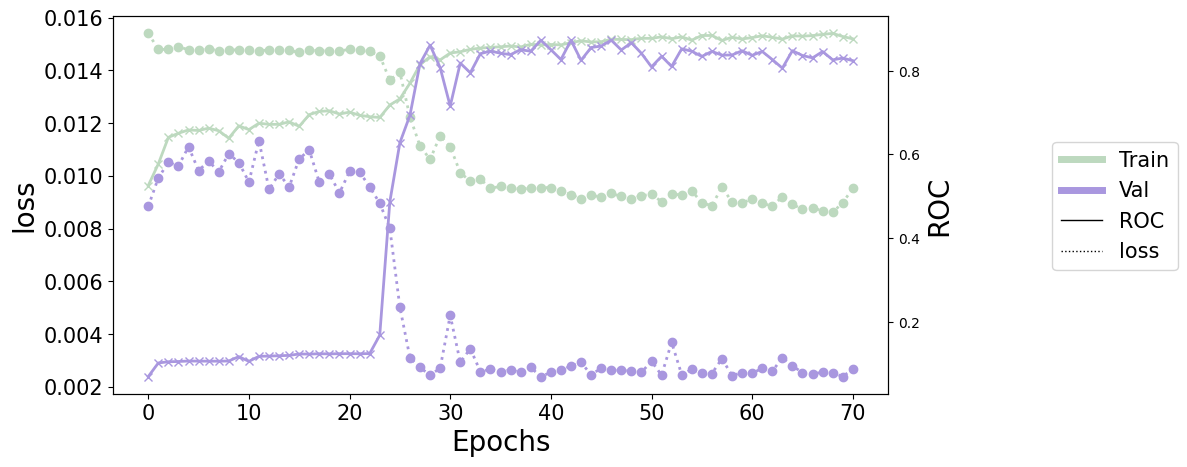

In [50]:
def plot_metrics(metrics, title=""):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=100)

    axs.plot(metrics['train_losses'], color="#BDD9BF", marker="o", label="Train loss", linestyle=":", linewidth=2)
    axs.plot(metrics['val_losses'], color="#A997DF", marker="o", label="Val loss", linestyle=":", linewidth=2)
    axs.set_ylabel("loss", fontsize=20)
    axs.set_xlabel("Epochs", fontsize=20)

    roc_axs = axs.twinx()
    roc_axs.plot(list(map(lambda x: x, metrics['train_rocs'])), color="#BDD9BF", marker="x", label="train roc", linewidth=2)
    roc_axs.plot(list(map(lambda x: x, metrics['val_rocs'])), color="#A997DF", marker="x", label="val roc", linewidth=2)
    roc_axs.set_ylabel("ROC", fontsize=20)

    # tick size
    for tick in axs.xaxis.get_major_ticks():
        tick.label.set_fontsize(15)

    for tick in axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)
        
    for tick in roc_axs.yaxis.get_major_ticks():
        tick.label.set_fontsize(15)


    # legend
    legend = []
    legend.append(Line2D([0,1], [1,0], color="#BDD9BF", label="Train", linewidth=5))
    legend.append(Line2D([0,1], [1,0], color="#A997DF", label="Val", linewidth=5))
    legend.append(Line2D([0,1], [1,0], color="black", label="ROC", linewidth=1))
    legend.append(Line2D([0,1], [1,0], color="black", linestyle=":",label="loss", linewidth=1))
    lgd = fig.legend(handles=legend, ncol=1, fontsize=15, loc="center right", fancybox=True, bbox_to_anchor=(1.0, 0.5, 0.2, 0))
    
    fig.suptitle(title, fontsize=20)
    
    return fig, axs

plot_metrics(metrics)

# 5. Evaluation

There are more baseline methods at the following URL: https://github.com/deepchem/moleculenet

We will look at AUC of ROC curve. 

ROC AUC score: 0.6754022545524616


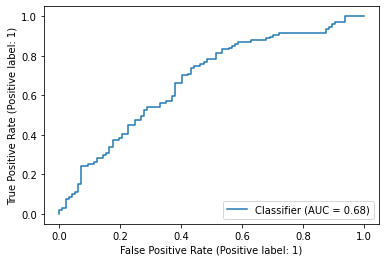

In [51]:
from sklearn.metrics import RocCurveDisplay


test_data = torch.utils.data.DataLoader(Subdataset(dataset, test_idx), batch_size=128, num_workers=2)

y_test, y_pred = [], []
for batch in test_data:
    x, A, D, EF, Y = [z.to(device) for z in batch]

    with torch.no_grad():
        outputs = model(x, A, D)
        y_pred += outputs.softmax(dim=-1).cpu().numpy().tolist()

    y_test += Y.cpu().numpy().tolist()

print(f'ROC AUC score: {roc_auc_score(y_true = y_test, y_score= y_pred)}')
RocCurveDisplay.from_predictions(y_test, y_pred)

# Summary


We looked at the following
- Learned key concepts required to work with molecules
- Performed critical data preprocessing tasks, such as feature extraction, graph formation, and scaffold splitting
- Explored challenges of drug discovery, particularly designing drugs that can cross the blood-brain barrier and enter the central nervous system
- Implemented Molecule Attention Transformer (MAT) proposed by Maziarka et al. (2020) using a deep learning pipeline
- Trained and evaluated the model on molecular datasets.

Note: We haven't used edge features in our model as Maziarka et al. (2020) noted in section 4.4 that edge features didn't help the models.